## Loading data

In [32]:
#imports

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import sklearn 
import numpy as np 
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import altair_ally as aly
import altair as alt
from xgboost import XGBRegressor
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR

In [2]:
df = pd.read_csv("data/raw/marketing-campaign-dataset.csv", encoding="utf-8")
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df

,campaign_item_id,no_of_days,time,ext_service_id,ext_service_name,creative_id,creative_width,creative_height,search_tags,template_id,...,exchange_rate,media_cost_usd,position_in_content,unique_reach,total_reach,search_tag_cat,cmi_currency_code,timezone,weekday_cat,keywords
10590,3157,8,2022-10-01,128,Facebook Ads,1995,300.0,250.0,#Timeless X Style,90.0,...,1,1.101480,NaN,NaN,NaN,Others,AED,Asia/Kolkata,week_day,bridal jewelry
7215,2802,17,2022-07-17,128,Facebook Ads,1730,0.0,0.0,#The X Factor - Fashion for the Fearless,23.0,...,1,1.169217,NaN,NaN,NaN,Others,EGP,Africa/Cairo,week_end,handmade jewelry
5081,2766,54,2022-06-01,128,Facebook Ads,1570,0.0,0.0,#The Power of X,23.0,...,1,5.824984,NaN,NaN,NaN,Youtube,USD,America/New_York,week_day,layered jewelry
70577,3099,20,2022-08-14,128,Facebook Ads,14340,NaN,NaN,#Timeless X Style,NaN,...,1,33.695737,NaN,NaN,NaN,Others,INR,Asia/Kolkata,week_end,dangle earrings
34278,3161,19,2022-07-05,128,Facebook Ads,7010,300.0,250.0,#The Ultimate Fashion Statement with X,90.0,...,1,0.839265,NaN,NaN,NaN,Others,AED,Asia/Kolkata,week_day,chic jewelry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63206,3216,31,2022-10-24,16,DV360,12560,300.0,250.0,#Timeless X Style,90.0,...,1,1.192337,NaN,NaN,NaN,Others,AED,Asia/Kolkata,week_day,affordable jewelry
61404,3213,20,2022-10-13,128,Facebook Ads,12060,300.0,250.0,#Be Bold. Be X,90.0,...,1,0.720463,NaN,NaN,NaN,Others,AED,Asia/Kolkata,week_day,summer jewelry
17730,3053,10,2022-09-02,16,DV360,3620,300.0,250.0,#Be Bold. Be X,90.0,...,1,75.348995,NaN,NaN,NaN,Others,INR,Asia/Kolkata,week_day,seasonal jewelry
28030,3155,6,2022-08-22,128,Facebook Ads,6085,300.0,250.0,#Embrace Your Individuality with X,90.0,...,1,0.836557,NaN,NaN,NaN,Others,AED,Asia/Kolkata,week_day,winter jewelry


### Checking for null values

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50828 entries, 10590 to 15725
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   campaign_item_id     50828 non-null  int64  
 1   no_of_days           50828 non-null  int64  
 2   time                 50828 non-null  object 
 3   ext_service_id       50828 non-null  int64  
 4   ext_service_name     50828 non-null  object 
 5   creative_id          50828 non-null  int64  
 6   creative_width       48436 non-null  float64
 7   creative_height      48436 non-null  float64
 8   search_tags          50828 non-null  object 
 9   template_id          48436 non-null  float64
 10  landing_page         50828 non-null  object 
 11  advertiser_id        50828 non-null  int64  
 12  advertiser_name      50828 non-null  object 
 13  network_id           50828 non-null  int64  
 14  approved_budget      50535 non-null  float64
 15  advertiser_currency  50828 non-null  

### Dropping the features with many nulls

In [5]:
train_df.describe()

,campaign_item_id,no_of_days,ext_service_id,creative_id,creative_width,creative_height,template_id,advertiser_id,network_id,approved_budget,...,max_bid_cpm,network_margin,campaign_budget_usd,impressions,clicks,exchange_rate,media_cost_usd,position_in_content,unique_reach,total_reach
count,50828.000000,50828.000000,50828.000000,50828.000000,48436.000000,48436.000000,48436.000000,50828.000000,50828.000000,5.053500e+04,...,5211.0,50828.0,50828.000000,50828.00000,50828.000000,50828.0,50828.000000,0.0,0.0,0.0
mean,3130.202231,27.128099,49.179901,7455.009935,267.767776,223.139813,83.073416,6195.398560,345.286082,1.256839e+05,...,1.0,0.0,614.491251,1358.38105,51.532226,1.0,11.675704,NaN,NaN,NaN
std,142.375546,25.536363,55.783878,4062.750623,92.902794,77.418995,20.860041,388.236484,23.633708,5.606503e+05,...,0.0,0.0,1342.596081,3750.39594,387.708663,0.0,48.937153,NaN,NaN,NaN
min,2733.000000,0.000000,4.000000,1000.000000,0.000000,0.000000,23.000000,4756.000000,188.000000,4.000000e+02,...,1.0,0.0,2.452316,511.00000,2.000000,1.0,0.000000,NaN,NaN,NaN
25%,3148.000000,9.000000,4.000000,3725.000000,300.000000,250.000000,90.000000,6319.000000,353.000000,6.000000e+03,...,1.0,0.0,208.566757,526.00000,5.000000,1.0,0.433018,NaN,NaN,NaN
50%,3173.000000,19.000000,16.000000,7885.000000,300.000000,250.000000,90.000000,6385.000000,353.000000,1.000000e+04,...,1.0,0.0,377.656676,577.00000,8.000000,1.0,1.713909,NaN,NaN,NaN
75%,3202.000000,37.000000,128.000000,11000.000000,300.000000,250.000000,90.000000,6394.000000,353.000000,1.500000e+04,...,1.0,0.0,755.313351,815.00000,13.000000,1.0,8.243305,NaN,NaN,NaN
max,3960.000000,118.000000,128.000000,15605.000000,300.000000,250.000000,93.000000,6490.000000,353.000000,6.000000e+06,...,1.0,0.0,39559.896155,153959.00000,31807.000000,1.0,2295.028945,NaN,NaN,NaN


### Column data types and first few rows

In [7]:
train_df.nunique()

campaign_item_id         157
no_of_days               119
time                     224
ext_service_id             3
ext_service_name           3
creative_id             2850
creative_width             2
creative_height            2
search_tags                6
template_id                5
landing_page              45
advertiser_id             47
advertiser_name           44
network_id                 6
approved_budget           61
advertiser_currency        5
channel_id                 5
channel_name               5
max_bid_cpm                1
network_margin             1
campaign_budget_usd      696
impressions             5491
clicks                  1060
stats_currency             5
currency_code              5
exchange_rate              1
media_cost_usd         50376
position_in_content        0
unique_reach               0
total_reach                0
search_tag_cat             5
cmi_currency_code          5
timezone                   7
weekday_cat                2
keywords      

### Distributions

In [8]:
import altair as alt
import vegafusion
alt.data_transformers.enable("vegafusion")


numeric_cols = train_df.select_dtypes("number").columns.tolist()
numeric_cols_dist = alt.Chart(train_df).mark_bar().encode(
    alt.X(alt.repeat(), type = "quantitative", bin = alt.Bin(maxbins = 20)),
    y ="count()",
).properties(
        width = 250,
        height = 150
).repeat(
    numeric_cols,
    columns = 3
)

numeric_cols_dist

alt.RepeatChart(...)

### Distribution of categorical columns

In [10]:
cat_cols = list(train_df.select_dtypes("object").columns.drop('time'))

categorical_cols_dist = alt.Chart(train_df).mark_bar().encode(
    x=alt.X(alt.repeat("repeat"), type="nominal"),
    y="count()",
).properties(
    width=550,
    height=150
).repeat(
    repeat=cat_cols,
    columns=1
)

categorical_cols_dist

alt.RepeatChart(...)

In [11]:
def missing_zero_values_table(df):

    zero_val = (df == 0.00).astype(int).sum(axis=0)
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(
    columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
    mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
    mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
    mz_table['Data Type'] = df.dtypes
    mz_table = mz_table[
        mz_table.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
           "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
    return mz_table
missing_zero_values_table(train_df)

Your selected dataframe has 35 columns and 50828 Rows.
There are 8 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
position_in_content,0,50828,100.0,50828,100.0,float64
unique_reach,0,50828,100.0,50828,100.0,float64
total_reach,0,50828,100.0,50828,100.0,float64
max_bid_cpm,0,45617,89.7,45617,89.7,float64
creative_width,5204,2392,4.7,7596,14.9,float64
creative_height,5204,2392,4.7,7596,14.9,float64
template_id,0,2392,4.7,2392,4.7,float64
approved_budget,0,293,0.6,293,0.6,float64


In [12]:
aly.corr(train_df)

/Users/monorouzi/miniconda3/envs/marketing-campaign/lib/python3.11/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/Users/monorouzi/miniconda3/envs/marketing-campaign/lib/python3.11/site-packages/altair/vegalite/v5/api.py:394: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/Users/monorouzi/miniconda3/envs/marketing-campaign/lib/python3.11/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/Users/monorouzi/miniconda3/envs/marketing-campaign/lib/python3.11/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.ConcatChart(...)

Text(0.5, 1.0, 'Service name vs clicks')

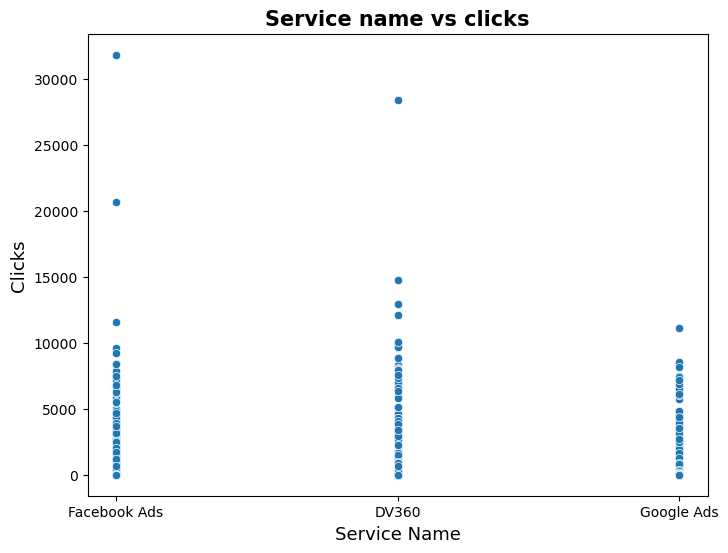

In [13]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='ext_service_name', y='clicks', data=train_df)

plt.xlabel("Service Name", size=13)
plt.ylabel("Clicks", size=13)
plt.title("Service name vs clicks",size=15, weight='bold')

Text(0.5, 1.0, 'Channel name vs clicks')

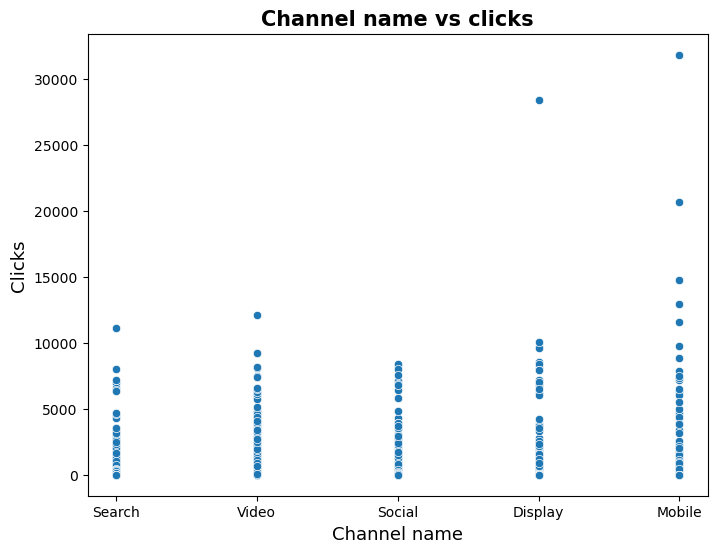

In [21]:

plt.figure(figsize=(8,6))
sns.scatterplot(x='channel_name', y='clicks', data=train_df)

plt.xlabel("Channel name", size=13)
plt.ylabel("Clicks", size=13)
plt.title("Channel name vs clicks",size=15, weight='bold')

## Preprocessing

In [48]:
train_df['creative_width'].fillna(train_df['creative_width'].mean(), inplace=True)
train_df['creative_height'].fillna(train_df['creative_height'].mean(), inplace=True)
train_df['approved_budget'].fillna(train_df['approved_budget'].mean(), inplace=True)
test_df['creative_width'].fillna(test_df['creative_width'].mean(), inplace=True)
test_df['creative_height'].fillna(test_df['creative_height'].mean(), inplace=True)
test_df['approved_budget'].fillna(test_df['approved_budget'].mean(), inplace=True)


X_train = train_df.drop(columns=['clicks'])
y_train = train_df['clicks']
X_test = test_df.drop(columns=['clicks'])
y_test = test_df['clicks']


categorical_features = [
    'ext_service_name', 
    'search_tags',
    'advertiser_name',
    'channel_name',
    'search_tag_cat',
    'timezone',
    'weekday_cat',
    'keywords'
]


numeric_features = [
    'no_of_days', 
    'creative_width', 
    'creative_height', 
    'approved_budget',
    'campaign_budget_usd',
    'impressions',
    'media_cost_usd'
]


drop_features = [
    'campaign_item_id',
    'time', 
    'ext_service_id', 
    'creative_id', 
    'template_id',
    'landing_page',
    'advertiser_id',
    'network_id',
    'channel_id',
    'max_bid_cpm',
    'network_margin',
    'advertiser_currency',
    'currency_code',
    'exchange_rate',
    'stats_currency',
    'position_in_content',
    'unique_reach', 
    'total_reach',
    'cmi_currency_code'
]
    

In [64]:
numeric_transformer = make_pipeline(
    StandardScaler()
)

categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown='ignore')
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features), 
    ('drop', drop_features)
)

In [65]:
# dummy model
model_dummy = DummyRegressor()

pipe_dummy = make_pipeline(preprocessor, model_dummy)

cv_df = pd.DataFrame(cross_validate(pipe_dummy, 
                                    X_train, 
                                    y_train, 
                                    return_train_score=True,
                                    scoring='r2'
))
cv_df

,fit_time,score_time,test_score,train_score
0,0.085300,0.011343,-2.437986e-04,0.0
1,0.049576,0.010809,-1.560743e-04,0.0
2,0.049278,0.010872,-7.472204e-05,0.0
3,0.049593,0.010968,-8.348712e-07,0.0
4,0.049779,0.010913,-1.404815e-04,0.0


In [66]:
# Linear Model  
pipe_ridge = make_pipeline(preprocessor, Ridge())

cv_df = pd.DataFrame(cross_validate(pipe_ridge, X_train, y_train, scoring='r2', return_train_score=True, cv=10))
cv_df

cross_val_results = {}
cross_val_results['ridge'] = cv_df.agg(['mean', 'std']).round(3).T
cross_val_results['ridge']

,mean,std
fit_time,0.112,0.013
score_time,0.006,0.000
test_score,0.537,0.181
train_score,0.477,0.031


In [67]:
# 2. Hyperparameter tuning 

param_dist = {"ridge__alpha": 10.0**np.arange(-5, 5) }

random_search = RandomizedSearchCV(
    pipe_ridge, 
    param_dist, 
    n_iter=100, 
    return_train_score=True, 
    random_state=123,
    n_jobs=-1 ,
    scoring='r2', 
    cv=5
)

random_search.fit(X_train, y_train)

The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['no_of_days',
                                                                                'creative_width',
                                                                                'creative_height',
                                                                                'approved_budget',
                                                                                'campaign_budget_usd',
                                                                                'impressions',
                                                                                'media_cost_usd']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('onehotencoder',
                                                                                                OneHotEnco...
                                                                                'advertiser_currency',
                                                                                'currency_code',
                                                                                'exchange_rate',
                                                                                'stats_currency',
                                                                                'position_in_content',
                                                                                'unique_reach',
                                                                                'total_reach',
                                                                                'cmi_currency_code'])])),
                                             ('ridge', Ridge())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'ridge__alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04])},
                   random_state=123, return_train_score=True, scoring='r2')

In [68]:
best_params = random_search.best_params_
best_r2 = random_search.best_score_

print("Best alpha:", best_params)
print("best score:", best_r2)

Best alpha: {'ridge__alpha': 10.0}
best score: 0.5083287179619348


In [69]:
# Randomforest
pipe_rf = make_pipeline(
    preprocessor,
    RandomForestRegressor(max_depth=10, random_state=123)
    )

cv_rf = pd.DataFrame(cross_validate(pipe_rf, X_train, y_train, cv = 5, return_train_score = True))
cv_rf

,fit_time,score_time,test_score,train_score
0,13.456315,0.049674,0.713064,0.922367
1,13.415338,0.049845,0.753108,0.911567
2,13.401640,0.049426,0.392495,0.911953
3,13.447377,0.049700,0.522552,0.919806
4,13.590936,0.050579,0.717907,0.924002


In [70]:
cross_val_results['randomforest'] = cv_rf.agg(['mean', 'std']).round(3).T
cross_val_results['randomforest']

,mean,std
fit_time,13.462,0.075
score_time,0.050,0.000
test_score,0.620,0.156
train_score,0.918,0.006


In [71]:
pipe_rf.fit(X_train, y_train)
model_rf = pipe_rf.named_steps['randomforestregressor']

In [72]:
feature_importances_rf = model_rf.feature_importances_
feature_importances_rf
feature_names_1 = pipe_rf.named_steps['columntransformer'].named_transformers_['pipeline-1'].get_feature_names_out().tolist()
feature_names_2 = pipe_rf.named_steps['columntransformer'].named_transformers_['pipeline-2'].get_feature_names_out().tolist()

feature_names = feature_names_1 + feature_names_2
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_rf})
feature_importances_rf_sorted = feature_importance_df.sort_values(by='Importance', ascending = False).head(10)
feature_importances_rf_sorted

,Feature,Importance
5,impressions,0.486005
0,no_of_days,0.098920
4,campaign_budget_usd,0.068378
6,media_cost_usd,0.052810
40,advertiser_name_Malad,0.045139
131,keywords_fall jewelry,0.037052
83,keywords_animal jewelry,0.029075
3,approved_budget,0.020693
97,keywords_body jewelry,0.011800
176,keywords_statement necklaces,0.009835


In [73]:
#XGBoost
pipe_xgb = make_pipeline(
    preprocessor,
    XGBRegressor(
        random_state=123, verbosity=0))
cv_df_xg = pd.DataFrame(cross_validate(pipe_xgb, X_train, y_train, cv = 5, return_train_score = True))
cv_df_xg

,fit_time,score_time,test_score,train_score
0,0.187859,0.018645,0.379648,0.993102
1,0.150633,0.020024,0.660365,0.993311
2,0.161584,0.019128,0.550660,0.991706
3,0.150842,0.017534,0.753742,0.991022
4,0.167620,0.018946,0.693675,0.993190


In [74]:
cross_val_results['XGBoost'] = cv_df_xg.agg(['mean', 'std']).round(3).T
cross_val_results['XGBoost']

,mean,std
fit_time,0.164,0.015
score_time,0.019,0.001
test_score,0.608,0.147
train_score,0.992,0.001


In [75]:
pipe_xgb.fit(X_train, y_train)
model_xg = pipe_xgb.named_steps['xgbregressor']

In [76]:
feature_importances_xgb = model_xg.feature_importances_
feature_importances_xgb
feature_names_1 = pipe_xgb.named_steps['columntransformer'].named_transformers_['pipeline-1'].get_feature_names_out().tolist()
feature_names_2 = pipe_xgb.named_steps['columntransformer'].named_transformers_['pipeline-2'].get_feature_names_out().tolist()

feature_names = feature_names_1 + feature_names_2
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_xgb})
feature_importances_xgb_sorted = feature_importance_df.sort_values(by='Importance', ascending = False).head(10)
feature_importances_xgb_sorted

,Feature,Importance
40,advertiser_name_Malad,0.191111
5,impressions,0.071391
39,advertiser_name_Maharashtra,0.070613
176,keywords_statement necklaces,0.043041
160,keywords_nature-inspired jewelry,0.036421
35,advertiser_name_Kuala Lumpur,0.035813
0,no_of_days,0.033141
4,campaign_budget_usd,0.033009
131,keywords_fall jewelry,0.025922
1,creative_width,0.023097


In [81]:
#lightgbm

from lightgbm import LGBMRegressor

pipe_lgbm = make_pipeline(
    preprocessor, LGBMRegressor(random_state=123)
)
cv_df_lgbm = pd.DataFrame(cross_validate(pipe_lgbm, X_train, y_train, cv = 5, return_train_score = True))
cv_df_lgbm

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1313
[LightGBM] [Info] Number of data points in the train set: 40662, number of used features: 186
[LightGBM] [Info] Start training from score 52.468644
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1314
[LightGBM] [Info] Number of data points in the train set: 40662, number of used features: 186
[LightGBM] [Info] Start training from score 50.603659
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

,fit_time,score_time,test_score,train_score
0,0.422324,0.018680,0.720323,0.780293
1,0.381098,0.017592,0.712940,0.786572
2,0.384109,0.017519,0.552246,0.800695
3,0.377298,0.018208,0.566256,0.792630
4,0.369689,0.016879,0.703416,0.785616


In [82]:
cross_val_results['LGBMRegressor'] = cv_df_lgbm.agg(['mean', 'std']).round(3).T
cross_val_results['LGBMRegressor']

,mean,std
fit_time,0.387,0.021
score_time,0.018,0.001
test_score,0.651,0.084
train_score,0.789,0.008


In [83]:
pipe_lgbm.fit(X_train, y_train)
model_lgbm = pipe_lgbm.named_steps['lgbmregressor']

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1314
[LightGBM] [Info] Number of data points in the train set: 50828, number of used features: 186
[LightGBM] [Info] Start training from score 51.532226


In [84]:
feature_importances_lgbm = model_lgbm.feature_importances_
feature_names_1 = pipe_lgbm.named_steps['columntransformer'].named_transformers_['pipeline-1'].get_feature_names_out().tolist()
feature_names_2 = pipe_lgbm.named_steps['columntransformer'].named_transformers_['pipeline-2'].get_feature_names_out().tolist()

feature_names = feature_names_1 + feature_names_2
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_lgbm})
feature_importances_lgbm_sorted = feature_importance_df.sort_values(by='Importance', ascending = False).head(10)
feature_importances_lgbm_sorted

,Feature,Importance
0,no_of_days,694
4,campaign_budget_usd,601
5,impressions,399
3,approved_budget,288
6,media_cost_usd,264
1,creative_width,104
40,advertiser_name_Malad,93
35,advertiser_name_Kuala Lumpur,52
34,advertiser_name_Karnataka,43
7,ext_service_name_DV360,36


In [85]:
pd.concat(cross_val_results, axis = 1)

ridge        randomforest        XGBoost        LGBMRegressor  \
              mean    std         mean    std    mean    std          mean   
fit_time     0.112  0.013       13.462  0.075   0.164  0.015         0.387   
score_time   0.006  0.000        0.050  0.000   0.019  0.001         0.018   
test_score   0.537  0.181        0.620  0.156   0.608  0.147         0.651   
train_score  0.477  0.031        0.918  0.006   0.992  0.001         0.789   

                    
               std  
fit_time     0.021  
score_time   0.001  
test_score   0.084  
train_score  0.008

In [86]:
rfecv = RFECV(Ridge())

pipe_rf_rfecv = make_pipeline(
    preprocessor, rfecv, LGBMRegressor(random_state=123)
)
cv_df_rfecv = pd.DataFrame(cross_validate(pipe_rf_rfecv, X_train, y_train,cv = 10, return_train_score = True))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 823
[LightGBM] [Info] Number of data points in the train set: 45745, number of used features: 30
[LightGBM] [Info] Start training from score 51.887266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 45745, number of used features: 47
[LightGBM] [Info] Start training from score 52.009553
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [87]:
pipe_rf_rfecv.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 903
[LightGBM] [Info] Number of data points in the train set: 50828, number of used features: 70
[LightGBM] [Info] Start training from score 51.532226


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['no_of_days',
                                                   'creative_width',
                                                   'creative_height',
                                                   'approved_budget',
                                                   'campaign_budget_usd',
                                                   'impressions',
                                                   'media_cost_usd']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['...
                                                   'ext_service_id',
                                                   'creative_id', 'template_id',
                                                   'landing_page',
                                                   'advertiser_id',
                                                   'network_id', 'channel_id',
                                                   'max_bid_cpm',
                                                   'network_margin',
                                                   'advertiser_currency',
                                                   'currency_code',
                                                   'exchange_rate',
                                                   'stats_currency',
                                                   'position_in_content',
                                                   'unique_reach',
                                                   'total_reach',
                                                   'cmi_currency_code'])])),
                ('rfecv', RFECV(estimator=Ridge())),
                ('lgbmregressor', LGBMRegressor(random_state=123))])

In [88]:
rfecv_fs = pipe_rf_rfecv.named_steps["rfecv"]
rfecv_fs.n_features_


79

In [89]:
cross_val_results['RFECV'] = cv_df_rfecv.agg(['mean', 'std']).round(3).T
cross_val_results['RFECV']

,mean,std
fit_time,38.179,0.733
score_time,0.011,0.000
test_score,0.612,0.143
train_score,0.673,0.024


In [90]:
pd.concat(cross_val_results, axis = 1)

ridge        randomforest        XGBoost        LGBMRegressor  \
              mean    std         mean    std    mean    std          mean   
fit_time     0.112  0.013       13.462  0.075   0.164  0.015         0.387   
score_time   0.006  0.000        0.050  0.000   0.019  0.001         0.018   
test_score   0.537  0.181        0.620  0.156   0.608  0.147         0.651   
train_score  0.477  0.031        0.918  0.006   0.992  0.001         0.789   

                     RFECV         
               std    mean    std  
fit_time     0.021  38.179  0.733  
score_time   0.001   0.011  0.000  
test_score   0.084   0.612  0.143  
train_score  0.008   0.673  0.024

In [92]:
from scipy.stats import uniform, randint
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

param_dist = {
    'lgbmregressor__learning_rate': uniform(loc=0.01, scale=0.3),  # Continuous uniform distribution between 0.01 and 0.3
    'lgbmregressor__num_leaves': randint(24, 80),  # Discrete uniform distribution between 24 and 80
    'lgbmregressor__max_depth': randint(3, 15),  # Discrete uniform distribution between 3 and 15
}

random_search = RandomizedSearchCV(estimator=pipe_lgbm, param_distributions=param_dist,
                                   n_iter=100, scoring='r2', cv=5, n_jobs=-1, random_state=123)

random_search.fit(X_train, y_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['no_of_days',
                                                                                'creative_width',
                                                                                'creative_height',
                                                                                'approved_budget',
                                                                                'campaign_budget_usd',
                                                                                'impressions',
                                                                                'media_cost_usd']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('onehotencoder',
                                                                                                OneHotEnco...
                   param_distributions={'lgbmregressor__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x150022510>,
                                        'lgbmregressor__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x134410090>,
                                        'lgbmregressor__num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x150218450>},
                   random_state=123, scoring='r2')

In [93]:
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'lgbmregressor__learning_rate': 0.11853659668669422, 'lgbmregressor__max_depth': 14, 'lgbmregressor__num_leaves': 58}


In [94]:
print("Best Score:", random_search.best_score_)

Best Score: 0.6598481433365918
